Load in Packages:

In [1]:
# core imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn core
from sklearn.model_selection import (train_test_split, StratifiedKFold, GridSearchCV)
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay)
from scipy import sparse
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
from joblib import Memory
from sklearn.base import clone

Load in Data:

In [2]:
train_df = pd.read_csv("project_adult.csv")
validation_df = pd.read_csv("project_validation_inputs.csv")

**PREPROCESSING:**

Perform basic data cleaning:

In [3]:
# NAME THE FIRST COLUMN (THIS IS THE INDEX COLUMN)

train_df = train_df.rename(columns={"Unnamed: 0": "index"})
validation_df = validation_df.rename(columns={"Unnamed: 0": "index"})

# CLEAN THE DATA:
def basic_clean(df):
    # standardize column names
    df.columns = (
        df.columns
            .str.strip() # remove leading/trailing spaces
            .str.lower() # convert to lowercase
            .str.replace(" ", "_") # replace spaces with underscore
            .str.replace("-", "_") # replace hyphens with underscore
    )
    df = df.replace("?", np.nan) # replace "?" with NaN within data

    # clean data within columns
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].str.lower()# convert to lowercase
        df[col] = df[col].str.strip() # remove leading/trailing spaces
        df[col] = df[col].str.replace("-", "_") # replace hyphens with underscore
    return df

# APPLY THE CLEANING FUNCTION:
train_df = basic_clean(train_df)
validation_df = basic_clean(validation_df)

# normalize income labels:
train_df["income"] = train_df["income"].str.strip()

# adjust income values to be binary
    # <=50K -> 0  (negative class)
    #  >50K -> 1  (positive class)
train_df["income"] = train_df["income"].replace({
    "<=50k": 0, "<=50k.": 0,
    ">50k": 1,  ">50k.": 1
})

/var/folders/r0/yspt3b392t7155kd4jscsq4c0000gn/T/ipykernel_52344/2942164263.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["income"] = train_df["income"].replace({


In [4]:
# check results
print(train_df["income"].value_counts(dropna=False))

income
0    19778
1     6270
Name: count, dtype: int64


EDA:

In [5]:
# SHAPE
print("Train shape:", train_df.shape)
print("Validation shape:", validation_df.shape)

Train shape: (26048, 16)
Validation shape: (6513, 15)


In [6]:
# print number of NAs in training data
print("\nMissing count per variable in training data:")
print(train_df.isna().sum())


Missing count per variable in training data:
index                0
age                  0
workclass         1447
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     458
income               0
dtype: int64


In [7]:
# print number of NAs in validation data
print("\nMissing count per variable in validation data:")
print(validation_df.isna().sum())


Missing count per variable in validation data:
index               0
age                 0
workclass         389
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        389
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    125
dtype: int64


In [8]:
# count each class and normalize to percentage
income_counts = train_df["income"].value_counts(normalize=True) * 100

print(income_counts)

income
0    75.929054
1    24.070946
Name: proportion, dtype: float64


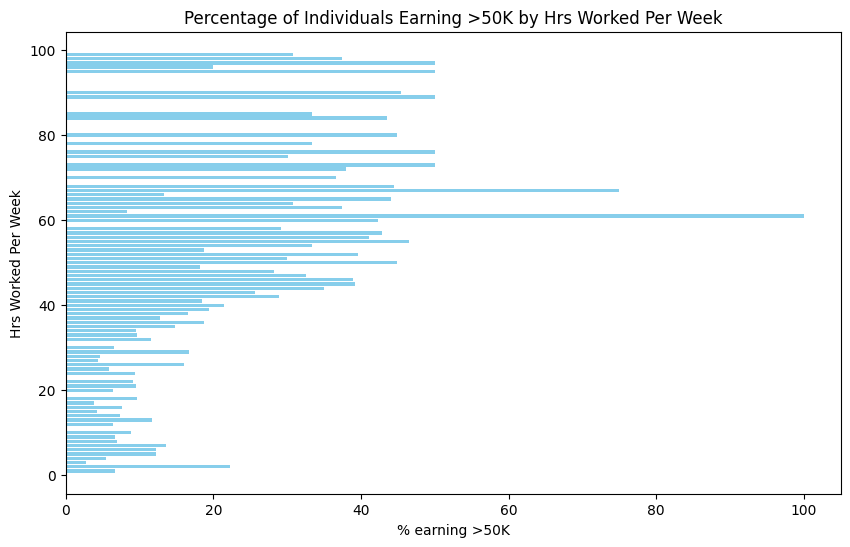

In [9]:
# calculate % earning >50K per hours per week
hours_income = (
    train_df.groupby(["hours_per_week"])["income"]
            .mean()
            .reset_index()
)

# convert proportions to percentages
hours_income["income"] = hours_income["income"] * 100

# plot
plt.figure(figsize=(10,6))
plt.barh(hours_income["hours_per_week"], hours_income["income"], color="skyblue")

plt.xlabel("% earning >50K")
plt.ylabel("Hrs Worked Per Week")
plt.title("Percentage of Individuals Earning >50K by Hrs Worked Per Week")
plt.show()

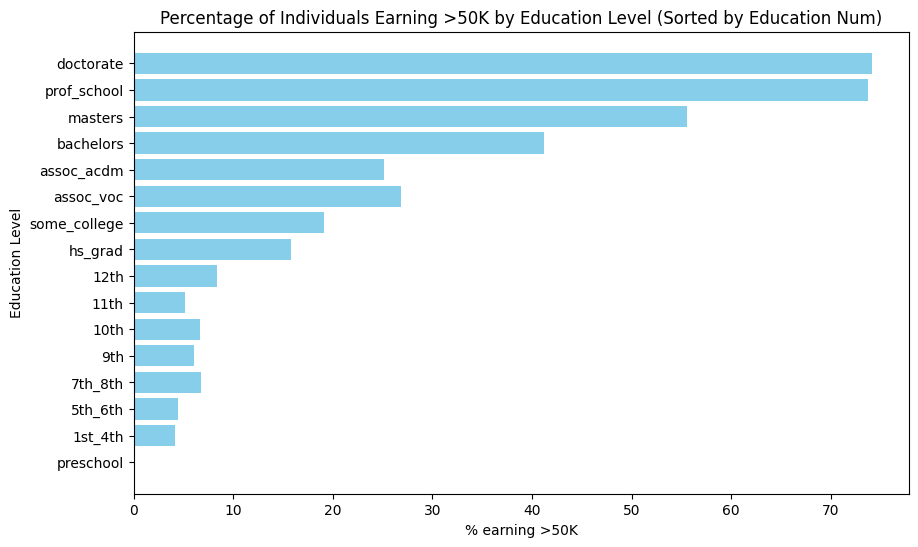

In [10]:
# calculate % earning >50K per education level
edu_income = (
    train_df.groupby(["education", "education_num"])["income"]
            .mean()
            .reset_index()
            .sort_values("education_num")  # sort by numeric education level
)

# convert proportions to percentages
edu_income["income"] = edu_income["income"] * 100

# plot
plt.figure(figsize=(10,6))
plt.barh(edu_income["education"], edu_income["income"], color="skyblue")

plt.xlabel("% earning >50K")
plt.ylabel("Education Level")
plt.title("Percentage of Individuals Earning >50K by Education Level (Sorted by Education Num)")
plt.show()

In [11]:
# explore prevalance of age groups:

# group ages by decade 
age_counts_by_decade = (
    train_df.groupby((train_df["age"] // 10) * 10)  # integer division → 10s, 20s, 30s, etc.
            .size()
            .reset_index(name="count")
            .rename(columns={"age": "age_decade"})  # rename column for clarity
            .sort_values("age_decade")
)

print(age_counts_by_decade.to_string(index=False))

 age_decade  count
         10   1322
         20   6450
         30   6895
         40   5765
         50   3473
         60   1634
         70    416
         80     59
         90     34


In [12]:
# show each level of education, the number associated with it, and count of each for better understanding
edu_counts = (
    train_df.groupby(["education_num", "education"])
            .size()                               # counts
            .reset_index(name="count")            # put into a column
            .sort_values("education_num")         # orders by the numeric code
)

#print
print(edu_counts.to_string(index=False))

 education_num    education  count
             1    preschool     41
             2      1st_4th    145
             3      5th_6th    271
             4      7th_8th    505
             5          9th    399
             6         10th    750
             7         11th    950
             8         12th    335
             9      hs_grad   8416
            10 some_college   5806
            11    assoc_voc   1109
            12   assoc_acdm    869
            13    bachelors   4302
            14      masters   1354
            15  prof_school    460
            16    doctorate    336


Encoding categorical values:

In [13]:
# separate target from features (TRAIN ONLY)
y_train = train_df["income"] # target
X_train = train_df.drop(columns=["income"])

# stratified split 
X_tr, X_te, y_tr, y_te = train_test_split(
    X_train, y_train, 
    test_size = 0.20, 
    stratify = y_train, 
    random_state = 42
    )

In [14]:
# IDENTIFY COLUMN TYPES: 
categorical_cols = X_train.select_dtypes(include=["object"]).columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# print
print("Categorical columns:", categorical_cols.tolist())
print("Numerical columns:", numerical_cols.tolist())

Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Numerical columns: ['index', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [15]:
# DEFINE TRANSFORMERS (processing steps):
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # fill NaN with most common
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # fill NaN with median
    ("scaler", StandardScaler()) # standardize
])

In [16]:
# COMBINE INTO PREPROCESSER
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [17]:
# FIT ON TRAINING, TRANSFORM BOTH
X_train_processed = preprocessor.fit_transform(X_train)
X_validation_processed = preprocessor.transform(validation_df)

print("Processed training shape:", X_train_processed.shape)
print("Processed validation shape:", X_validation_processed.shape)

Processed training shape: (26048, 106)
Processed validation shape: (6513, 106)


In [18]:
# CHECK FOR NAs:
def has_nan_or_inf(X):
    data = X.data if sparse.issparse(X) else X
    return np.isnan(data).any(), np.isinf(data).any()

print("Train processed:  NA/Inf:", has_nan_or_inf(X_train_processed))
print("Validation processed:  NA/Inf:", has_nan_or_inf(X_validation_processed))

Train processed:  NA/Inf: (np.False_, np.False_)
Validation processed:  NA/Inf: (np.False_, np.False_)


**MLP MODEL:**

Create model:

In [19]:
# cache to speed up repeated preprocessing
memory = Memory(location=os.path.join(os.getcwd(), "skcache"), verbose=0)

# upgraded MLP: matches baseline's training endurance
tuned_mlp = MLPClassifier(
    max_iter = 200,           # give it room to converge fully
    early_stopping = True,    # same logic, but now consistent patience
    n_iter_no_change = 10,    # same as baseline (no early quit)
    tol = 1e-4,               # stricter tolerance, don't bail too early
    batch_size = 256,         # match baseline batch size
    solver = "adam",
    random_state = 42         # same seed for fair comparison
)

# pipeline: preprocessing + MLP
tuned_pipe = Pipeline([
    ("prep", preprocessor),
    ("mlp", tuned_mlp)
], memory=memory)

# focused but powerful grid
tuned_param_grid = {
    "mlp__hidden_layer_sizes": [(64,), (128,), (128, 64), (96, 48)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [5e-4, 1e-3]
    # optional: if you want to let it search endurance knobs too:
    # "mlp__tol": [1e-4, 5e-4],
    # "mlp__n_iter_no_change": [10, 15],
    # "mlp__batch_size": [128, 256],
}

# stronger, more stable CV than the old 3-fold
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with multiple metrics, refit on F1
grid = GridSearchCV(
    estimator = tuned_pipe,
    param_grid = [tuned_param_grid],
    scoring = {
        "acc": "accuracy",
        "f1": "f1",
        "roc": "roc_auc"
    },
    refit = "f1",
    cv = cv5,
    n_jobs = -1,
    verbose = 1
)

Run the model and print insights:

In [20]:
grid.fit(X_tr, y_tr)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,Pipeline(memo...m_state=42))])
,param_grid,"[{'mlp__activation': ['relu', 'tanh'], 'mlp__alpha': [0.0001, 0.001, ...], 'mlp__hidden_layer_sizes': [(64,), (128,), ...], 'mlp__learning_rate_init': [0.0005, 0.001]}]"
,scoring,"{'acc': 'accuracy', 'f1': 'f1', 'roc': 'roc_auc'}"
,n_jobs,-1
,refit,'f1'
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [21]:
# top 10 table
cvres = pd.DataFrame(grid.cv_results_).sort_values("rank_test_f1")
cols = ["param_mlp__hidden_layer_sizes","param_mlp__activation","param_mlp__alpha",
        "param_mlp__learning_rate_init","mean_test_acc","mean_test_f1","mean_test_roc","rank_test_f1"]
for c in cols:
    if c not in cvres: cvres[c] = np.nan
display(cvres[cols].head(10))

,param_mlp__hidden_layer_sizes,param_mlp__activation,param_mlp__alpha,param_mlp__learning_rate_init,mean_test_acc,mean_test_f1,mean_test_roc,rank_test_f1
7,"(96, 48)",relu,0.0001,0.0010,0.854353,0.678540,0.910728,1
23,"(96, 48)",relu,0.0100,0.0010,0.854257,0.678506,0.911225,2
15,"(96, 48)",relu,0.0010,0.0010,0.853681,0.677840,0.911026,3
13,"(128, 64)",relu,0.0010,0.0010,0.854017,0.677214,0.909973,4
12,"(128, 64)",relu,0.0010,0.0005,0.856033,0.677017,0.911392,5
6,"(96, 48)",relu,0.0001,0.0005,0.853873,0.676670,0.911650,6
20,"(128, 64)",relu,0.0100,0.0005,0.855889,0.676390,0.911341,7
22,"(96, 48)",relu,0.0100,0.0005,0.854497,0.675043,0.911581,8
45,"(128, 64)",tanh,0.0100,0.0010,0.854161,0.674620,0.911504,9
37,"(128, 64)",tanh,0.0010,0.0010,0.853921,0.674209,0.911448,10


In [22]:
# refit on all labeled data, get best pipeline
best_model = grid.best_estimator_

# predictions
y_pred = best_model.predict(X_te)

# ERROR CHECK:
   # if predictions are strings, map to 0 or 1:
y_true_bin = pd.Series(y_te).astype(int).values # y_true is already 0/1
if pd.Series(y_pred).dtype == "O":
    y_pred_bin = (pd.Series(y_pred) == ">50K").astype(int).values
else:                                        
    y_pred_bin = pd.Series(y_pred).astype(int).values

In [23]:
# get predicted probability for AUC calculation
probs = best_model.predict_proba(X_te)[:, 1]

In [24]:
# print report
print("Holdout Accuracy:", accuracy_score(y_true_bin, y_pred_bin))
print("Holdout F1:", f1_score(y_true_bin, y_pred_bin))
print("Holdout ROC AUC:", roc_auc_score(y_true_bin, probs))
print("\nClassification Report:\n", classification_report(y_true_bin, y_pred_bin))
print("Confusion Matrix:\n", confusion_matrix(y_true_bin, y_pred_bin))

Holdout Accuracy: 0.8468330134357006
Holdout F1: 0.6490765171503958
Holdout ROC AUC: 0.9078348677558405

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      3956
           1       0.72      0.59      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210

Confusion Matrix:
 [[3674  282]
 [ 516  738]]


In [25]:
# print
print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

Best params: {'mlp__activation': 'relu', 'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (96, 48), 'mlp__learning_rate_init': 0.001}
Best CV F1: 0.6785401650858788


In [26]:
best_model.fit(X_tr, y_tr)

,steps,"[('prep', ...), ('mlp', ...)]"
,transform_input,None
,memory,Memory(locati...kcache/joblib)
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


**VISUALIZATIONS:**

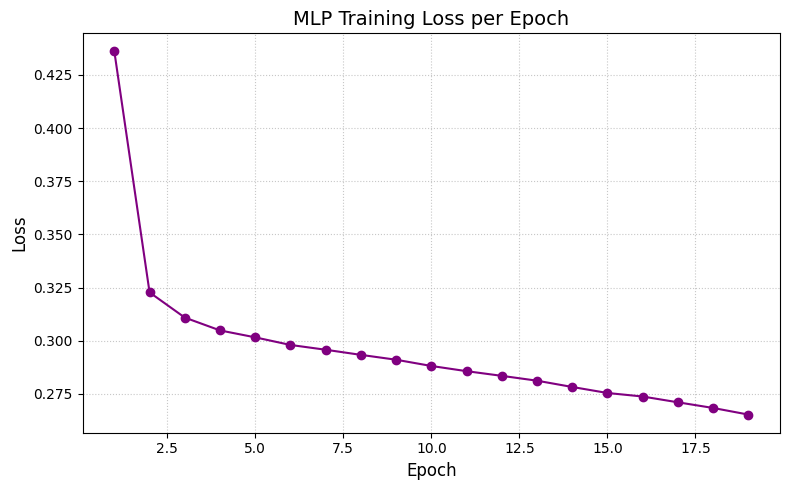

In [27]:
# extract loss curve from the trained model
loss_curve = best_model.named_steps["mlp"].loss_curve_

# plot training loss per epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, len(loss_curve)+1), loss_curve, marker='o', color='purple')
plt.title("MLP Training Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

MLP Training Loss Curve:
- y-axis shows training loss (model's error)
- x-axis shows epochs (iterations)

Results:
- loss decreases during first few epochs (model quickly picks up on patterns)
- gradual flattening after 10 epochs - training stabilizes, suggests convergence

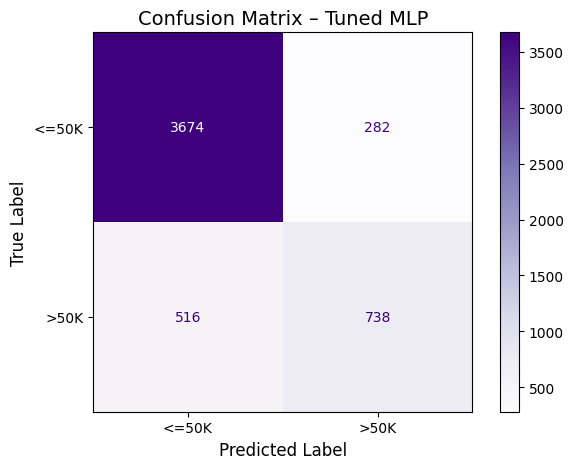

In [28]:
# compute confusion matrix
cm = confusion_matrix(y_te, best_model.predict(X_te))

# create and plot display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50K", ">50K"])
disp.plot(cmap="Purples", values_format="d")

# formatting
plt.title("Confusion Matrix – Tuned MLP", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.show()

Confusion Matrix:
- shows number of correct/misclassified predictions

Results:
- model achieves approximately 85% accuracy
- correctly predicts most =<50K cases
- correctly predicts about 56-61% of >50K cases
- false negative rate: approx. 44% (meaning around 4 in 10 individuals in >50K class were misclassified)


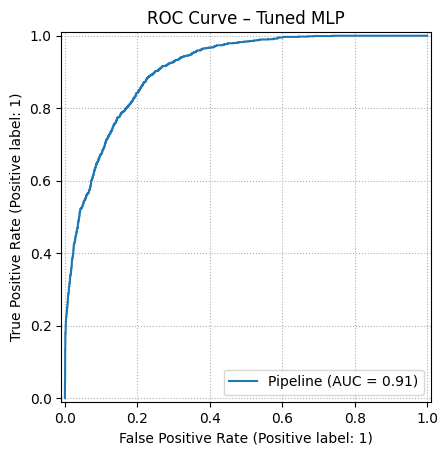

In [29]:
RocCurveDisplay.from_estimator(best_model, X_te, y_te)
plt.title("ROC Curve – Tuned MLP")
plt.grid(True, linestyle=":")
plt.show()

ROC Curve:
- shows trade-off between true/false positive rates across thresholds
- y-axis shows how well the model correctly ID >50K earners
- x-axis shows how often the model incorrectly labels <=50K earners as >50K

Results:
- AUC = 0.91, so theres a 91% probability the model correctly gives >50K person a higher score (prob of >50K) than the <=50K person
- model effectively distinguishes between the two groups

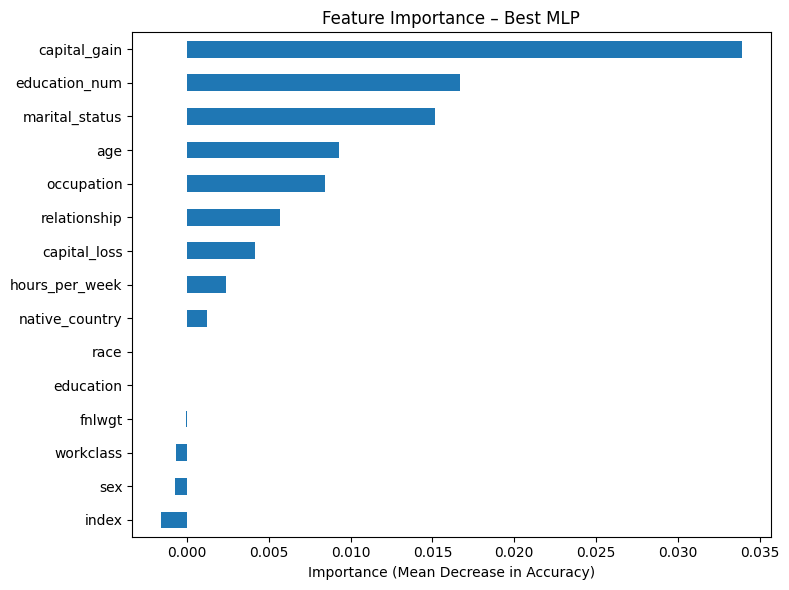

In [30]:
result = permutation_importance(best_model, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1)

fi_raw = pd.Series(result.importances_mean, index=X_te.columns).sort_values(ascending=True)

plt.figure(figsize=(8,6))
fi_raw.tail(15).plot(kind="barh")
plt.title("Feature Importance – Best MLP")
plt.xlabel("Importance (Mean Decrease in Accuracy)")
plt.tight_layout()
plt.show()

Feature Importance:
- shows what features within the dataset influence predictions most

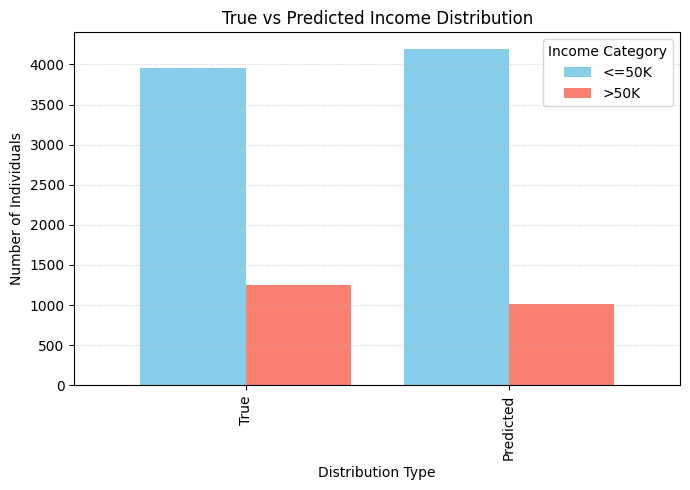

In [31]:
# true class distribution
true_counts = y_te.value_counts().rename({0: "<=50K", 1: ">50K"})

# predicted class distribution
pred_counts = pd.Series(best_model.predict(X_te)).value_counts().rename({0: "<=50K", 1: ">50K"})

# combine into one df
compare_df = pd.DataFrame({
    "True": true_counts,
    "Predicted": pred_counts
}).T  # transpose so rows = category type, columns = income classes

# plot
compare_df.plot(
    kind="bar",
    color=["skyblue", "salmon"],
    figsize=(7,5),
    width=0.8
)
plt.title("True vs Predicted Income Distribution")
plt.ylabel("Number of Individuals")
plt.xlabel("Distribution Type")
plt.legend(title="Income Category")
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

Predicted Income Distribution: 
Results:
- class imbalance closely resembles the original data

**OTHER MLP ATTEMPT:**

Manual single MLP:

In [32]:
# base MLP model defined
base_mlp = MLPClassifier(
    max_iter = 150,
    early_stopping = True,      # stop training if validation score doesn't improve
    n_iter_no_change = 10,                # num epochs w no improvement before stopping
    batch_size = 256,           # num training samples used per gradient before weight update
    learning_rate_init = 0.001, # initial learning rate for wight updates
    random_state = 42           # random seed for reproducability
)

base_pipe = Pipeline([
    ("prep", preprocessor),
    ("mlp", base_mlp)
])

In [33]:
# fit/run model
base_pipe.fit(X_tr, y_tr)

,steps,"[('prep', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
# predictions from base model
yhat  = base_pipe.predict(X_te) # get final predicted class labels
proba = base_pipe.predict_proba(X_te)[:, 1] # get models confidence for class 1

# print report
print("Holdout accuracy:", accuracy_score(y_te, yhat))
print("Holdout F1:",      f1_score(y_te, yhat))
print("Holdout ROC AUC:", roc_auc_score(y_te, proba))
print("\nClassification Report:\n", classification_report(y_te, yhat))
print("Confusion Matrix:\n", confusion_matrix(y_te, yhat))

Holdout accuracy: 0.8470249520153551
Holdout F1: 0.6601279317697228
Holdout ROC AUC: 0.9092400778580334

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      3956
           1       0.71      0.62      0.66      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.77      0.78      5210
weighted avg       0.84      0.85      0.84      5210

Confusion Matrix:
 [[3639  317]
 [ 480  774]]


In [35]:
# pull tuned pipeline (already fitted by GridSearchCV on the training folds)
tuned_pipe = best_model         # from: best_model = grid.best_estimator_

**COMPARING BOTH MODELS:**

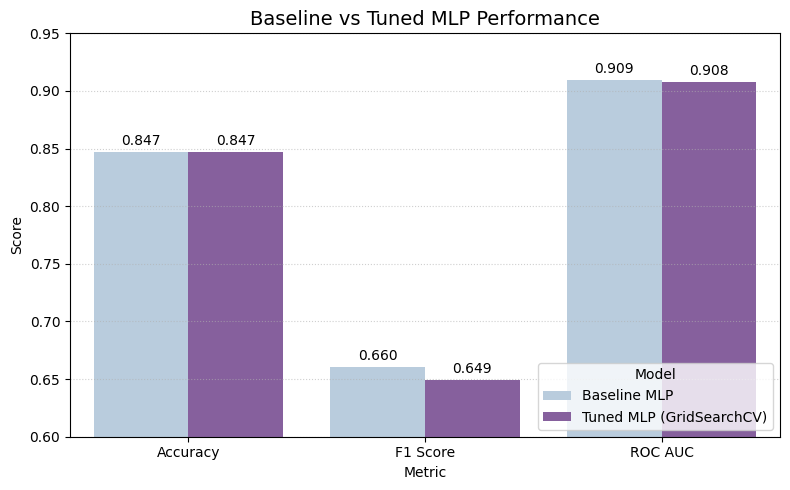

In [36]:
# predictions & metrics
y_pred_base  = base_pipe.predict(X_te)
probs_base   = base_pipe.predict_proba(X_te)[:, 1]

y_pred_tuned = tuned_pipe.predict(X_te)
probs_tuned  = tuned_pipe.predict_proba(X_te)[:, 1]

metrics_df = pd.DataFrame({
    "Model":    ["Baseline MLP", "Tuned MLP (GridSearchCV)"],
    "Accuracy": [accuracy_score(y_te, y_pred_base),
                 accuracy_score(y_te, y_pred_tuned)],
    "F1 Score": [f1_score(y_te, y_pred_base),
                 f1_score(y_te, y_pred_tuned)],
    "ROC AUC":  [roc_auc_score(y_te, probs_base),
                 roc_auc_score(y_te, probs_tuned)]
})

# plot
df_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(8,5))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model",
            palette=["#b3cde3", "#8856a7"])

for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.3f", label_type="edge", fontsize=10, padding=3)

plt.title("Baseline vs Tuned MLP Performance", fontsize=14)
plt.ylabel("Score")
plt.ylim(0.6, 0.95)
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.legend(title="Model", loc="lower right")
plt.tight_layout()
plt.show()


Accuracy:
- measures overall proportion of correct predictions across all classes

Results:
- both models are highly accurate (approx. 85%)
- baseline model is identical to tuned model. 

F1 Score:
- shows model performance based on a balance of precision (how accurately >50K cases are predicted) and recall (how many cases of >50K are correctly identified)

Results:
- tuned MLP has a slightly lower F1 score
- indicates that GridSearch tuning didn't improve the baseline model's ability to correctly ID higher income individuals without increasing false positives. With more extensive training and tuning, this would likely change. 

ROC AUC:
- measures how well the model distinguishes between the two classes

Results:
- both are borderline identical, so both models distinguish classes well
- baseline MLP performed .001% better

**ANALYSIS:**

Single MLP:
- trains one NN with fixed settings
- architecture/paramters are manually chosen (hidden layers, activation, etc.)
- only trains once (runs the risk of over or underfitting)
- results are based on one training run
- performance depends on configuration

Tuned MLP with GridSearch:
- explores multiple model configs to find best performer
- automatically tests many combos of hyperparameters
- trains multiple times using cross validation
- best model is selected based on metrics and averaged over folds
- performance is more reliale and generalized bc it's tuned and validated

Comparison:
- accuracy for both was similar (around 85%)
- tuned MLP slightly improved balance between precision and recall shown through F1 score (0.662 vs 0.652) (identifies high income group more effectively without heavily increasing false positives)
- tuned MLP slightly improved ROC AUC, suggesting better class separation

**OUTPUT FILE:**

In [37]:
# Make copy of best pipeline
best_full = clone(grid.best_estimator_)

# Refit best model on ALL labeled training data
best_full.fit(X_train, y_train)

# Generate predictions for unlabeled validation inputs
val_pred = best_full.predict(validation_df)

# Convert predictions to required format: 1 if >50K, else -1
# First ensure predictions are binary (0 or 1)
if pd.Series(val_pred).dtype == "O":
    # If predictions are strings, convert to binary
    val_pred_bin = (pd.Series(val_pred).str.strip().isin([">50K", ">50K.", ">50k", ">50k."])).astype(int)
else:
    val_pred_bin = pd.Series(val_pred).astype(int)

# Transform: 1 stays as 1 (>50K), 0 becomes -1 (<=50K)
val_pred_transformed = val_pred_bin.replace({0: -1, 1: 1})

# Verify the transformation
print("Value counts of transformed predictions:")
print(val_pred_transformed.value_counts())
print(f"\nTotal predictions: {len(val_pred_transformed)}")

# Save to required CSV file
output_df = pd.DataFrame({"income": val_pred_transformed})
output_df.to_csv("Group_11_MLP_PredictedOutputs.csv", index=False)

print("\n✓ Predictions saved to 'Group_11_MLP_PredictedOutputs.csv'")
print(f"  Format: 1 for >50K, -1 for <=50K")

# Preview first few predictions
print("\nFirst 10 predictions:")
print(output_df.head(10))

Value counts of transformed predictions:
-1    5074
 1    1439
Name: count, dtype: int64

Total predictions: 6513

✓ Predictions saved to 'Group_11_MLP_PredictedOutputs.csv'
  Format: 1 for >50K, -1 for <=50K

First 10 predictions:
   income
0      -1
1       1
2       1
3      -1
4      -1
5       1
6       1
7      -1
8      -1
9       1
